In [17]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./trajopt/scaling.jl")
include("./funlopt/funl_dynamics.jl")
include("./funlopt/funl_utils.jl")
include("./funlopt/funl_constraint.jl")

impose (generic function with 3 methods)

In [2]:
# Setting
type_funnel_dynamics = "Basic" # Basic, Lyapunov
type_nonlinearity = "Linear" # Linear Lipschitz Lsmooth
type_Z_parameterization = "FOH" # ZOH, FOH
type_funl_ctcs = false # true or false

false

In [3]:
# load nominal trajectory
using JLD2, FileIO
@load "./data/nominal_traj_unicycle_0324" my_dict
xnom = my_dict["x"]
unom = my_dict["u"]
tnom = my_dict["t"];
N = size(xnom,2) - 1
dtnom = zeros(N)
for i in 1:N
    dtnom[i] = tnom[i+1]-tnom[i]
end
@assert size(xnom,2) - 1 == N

In [4]:
function get_H_obs(rx,ry)
    return diagm([1/rx,1/ry])
end
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.5,0.5)
push!(c_list,c1)
push!(H_list,H1)
c2 = [4,3]
H2 = get_H_obs(0.5,0.5)
push!(c_list,c2)
push!(H_list,H2)

vmax = 2.0
vmin = 0.0
wmax = 2.0
wmin = -2.0
list_const = [InputConstraint([1;0],vmax),
    InputConstraint([-1;0],-vmin),
    InputConstraint([0; 1],wmax),
    InputConstraint([0; -1],-wmin),
    ObstacleAvoidance(H_list[1],c_list[1]),
    ObstacleAvoidance(H_list[2],c_list[2])
    ]

6-element Vector{FunnelConstraint}:
 InputConstraint([1, 0], 2.0)
 InputConstraint([-1, 0], -0.0)
 InputConstraint([0, 1], 2.0)
 InputConstraint([0, -1], 2.0)
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2])
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])

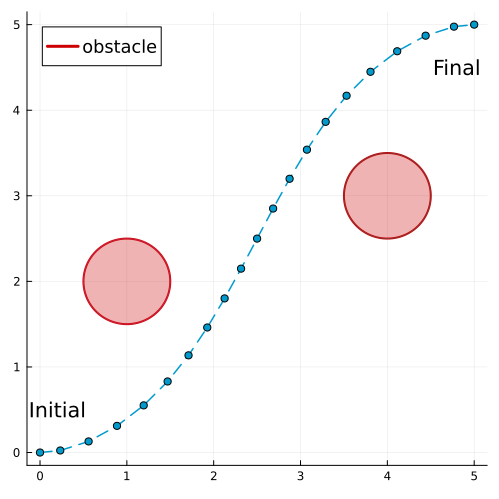

In [5]:
p2 = Plots.plot(; size=(500,500))
plot!(xnom[1,:],xnom[2,:],c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
scatter!(xnom[1,:],xnom[2,:],c=:deepskyblue3,linewidth=1.5,label=nothing)
for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
    label = nothing
    if idx == 1
        label = "obstacle"
    end
    plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
end
annotate!(0.2, 0.5, text("Initial", :black, :center))
annotate!(4.8, 4.5, text("Final", :black, :center))
display(p2)


In [6]:
dynamics = Unicycle()
alpha = 0.1
ix = size(xnom,1)
iu = size(unom,1)
DLMI = Basic_type(alpha,ix,iu,0)

Basic_type(0.1, 3, 2, 6, 6, 0, 6, 12, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1, 4, 5, 7, 8, 9], sparse([1, 2, 4, 5, 3, 7, 6, 8, 9], [1, 2, 2, 3, 4, 4, 5, 5, 6], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 9, 6))

In [7]:
Qnom = zeros(ix,ix,N+1)
Ynom = zeros(iu,ix,N+1)
ZLnom = zeros(ix,ix,N);
ZRnom = zeros(ix,ix,N);
Qini = diagm([0.08,0.08,0.06])
Qf = diagm([0.08,0.08,0.06])
for i in 1:N+1
    Qnom[:,:,i] .= Qini
end
Xnom,ULnom,URnom = QYZ_to_XULR(Qnom,Ynom,ZLnom,ZRnom);

In [8]:
xmin = [0;0;0];
xmax = [5;5;pi];
umin = [0;0];
umax = [vmax;wmax];
scaler = Scaling(xmin, xmax, umin, umax, tnom[end],0,0)

Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 5.0, 0.0, 0.0, 2.7659090097e-314)

In [112]:
include("./funlopt/funl_synthesis.jl")
include("./funlopt/funl_dynamics.jl")

discretize_foh_with_Nsub (generic function with 1 method)

In [113]:
param = Dict()
param["N"] = N
param["Nsub"] = 1
param["max_iter"] = 1;
param["w_funl"] = 1.0;
param["w_vc"] = 0.0;
param["w_tr"] = 0.0;
param["tol_vc"] = 1e-6;
param["tol_tr"] = 1e-4;
param["tol_dyn"] = 1e-1;
param["verbosity"] = false;

In [114]:
fs = FunnelSynthesis(param,dynamics,DLMI,list_const,scaler)

FunnelSynthesis(Unicycle(3, 2, 2, 2, 2, 2, [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [1 0; 0 1; 0 0], [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [0.0, 0.0]), Basic_type(0.1, 3, 2, 6, 6, 0, 6, 12, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1, 4, 5, 7, 8, 9], sparse([1, 2, 4, 5, 3, 7, 6, 8, 9], [1, 2, 2, 3, 4, 4, 5, 5, 6], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 9, 6)), FunnelConstraint[InputConstraint([1, 0], 2.0), InputConstraint([-1, 0], -0.0), InputConstraint([0, 1], 2.0), InputConstraint([0, -1], 2.0), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2]), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])], Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 5.0, 0.0, 0.0, 2.7659090097e-314), FunnelSolution([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

In [115]:
time_dict = run(fs,Xnom,ULnom,URnom,Qini,Qf,xnom,unom,dtnom,"Mosek")

|1      |-2.94       |-1.000    |-2.937     |-1.000     |-1.000    |-Inf     | 0.3      |-8.2e+00   |


Dict{Any, Any} with 5 entries:
  "time_discretization"     => 0.334442
  "time_discretization_sub" => 4.1e-8
  "time_cvxopt"             => 1.25692
  "time_solve"              => 0.125705
  "time_multiple_shooting"  => 0.100256

In [102]:
tprop,xprop,uprop = fs.solution.tprop,fs.solution.xprop,fs.solution.uprop
Xprop,Uprop = fs.solution.Xprop,fs.solution.Uprop
Qprop,Yprop,Zprop = XU_to_QYZ(Xprop,Uprop,ix,iu)
Qnode,Ynode,ZLnode,ZRnode = XULR_to_QYZ(fs.solution.X,fs.solution.UL,fs.solution.UR,ix,iu)

([6.70255299383294 -1.4446028472906391 2.640455871130678; -1.4446028472906391 3.536379331011608 -2.4742660190285712; 2.640455871130678 -2.4742660190285712 3.0385562875536616;;; 5.9677101015902565 -0.8760725981198486 2.4744343387280847; -0.8760725981198486 2.6610261422303227 -1.8430187925602737; 2.4744343387280847 -1.8430187925602737 2.680292336301385;;; 5.070832565654286 -0.18913678294276468 2.150417567499938; -0.18913678294276468 1.8409860487668146 -1.175006286045577; 2.150417567499938 -1.175006286045577 2.25273992150238;;; … ;;; 0.2171710440572821 0.09771417810299854 -0.15404215761328077; 0.09771417810299854 0.1340290455305212 -0.1629737707275178; -0.15404215761328077 -0.1629737707275178 0.2606142480794091;;; 0.14118274256026545 0.02565719834508541 -0.06676111699131176; 0.02565719834508541 0.07745141852291901 -0.0779699939014412; -0.06676111699131176 -0.0779699939014412 0.12403731107041407;;; 0.07969513328053338 0.00013237965833645841 -0.00025600843018741066; 0.00013237965833645841 0

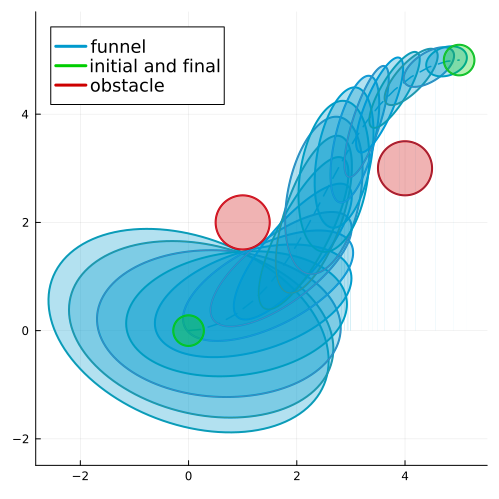

In [103]:
p2 = Plots.plot(; size=(500,500))
plot!(xnom[1,:],xnom[2,:],aspect_ratio=:equal,c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
for idx in 1:N
    label = nothing
    if idx == 1
        label = "funnel"
    end
    plot_ellipse(p2,Qnode[:,:,idx],xnom[:,idx],"deepskyblue3",label=label)
end
plot_ellipse(p2,fs.solution.Qi,xnom[:,1],"green3",label="initial and final")
plot_ellipse(p2,fs.solution.Qf,xnom[:,end],"green3")
for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
    label = nothing
    if idx == 1
        label = "obstacle"
    end
    plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
end
display(p2)

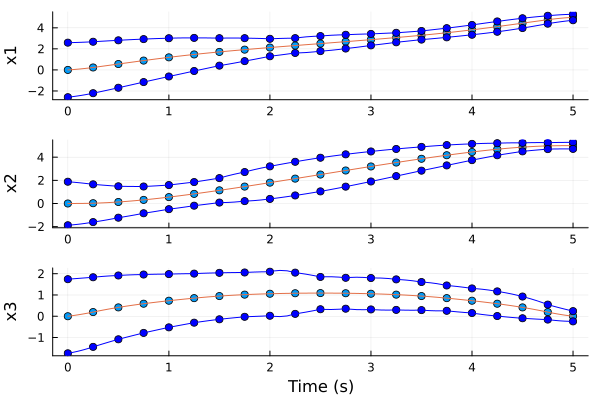

In [104]:
p = []
for idx in 1:3
    push!(p,plot(tnom,xnom[idx,:],seriestype = :scatter,label=""))
    plot!(tprop,xprop[idx,:],label="")
    plot!(tnom,xnom[idx,:] + sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] + sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    plot!(tnom,xnom[idx,:] - sqrt.(Qnode[idx,idx,:]),color=:blue,seriestype = :scatter,label="")
    plot!(tprop,xprop[idx,:] - sqrt.(Qprop[idx,idx,:]),color=:blue,label="")
    if idx == 3
        xlabel!("Time (s)")
    end
    ylabel!("x" * string(idx))
end
plot(p[1],p[2],p[3],layout=(3,1))

# Input funnel

In [105]:
function project_onto_input(Q,Y) 
    R = []
    for i in 1:size(Q,3)
        K = Y[:,:,i] * inv(Q[:,:,i])
        push!(R,K*Q[:,:,i]*K')
    end
    projected_input_funl = []
    for j in 1:iu
        a = zeros(iu)
        a[j] = 1
        each_funl = []
        for i in 1:length(R)
            push!(each_funl,sqrt(a'*R[i]*a))
        end
        push!(projected_input_funl,each_funl)
    end
    return projected_input_funl
end
input_proj_funl_prop = project_onto_input(Qprop,Yprop)
input_proj_funl_nom = project_onto_input(Qnode,Ynode)

2-element Vector{Any}:
 Any[0.5831409227412954, 0.7055146816128517, 0.543703768369525, 0.4594723348390434, 0.419818318924395, 0.4396052193309173, 0.4490428003539736, 0.4276306206597454, 0.4175252339017934, 0.41331400532303997  …  0.4133742624704599, 0.41752390525628924, 0.42742888735489504, 0.448711017761012, 0.43904097715545487, 0.41809338679239355, 0.45738353482492927, 0.5426827042327238, 0.7061948790451901, 0.5819144395418898]
 Any[0.8927717516674833, 1.0115135060500813, 1.2281827535037686, 1.3895315393721162, 1.4832305416172418, 1.5466564865538572, 1.673160924450144, 1.787876122386164, 1.8728562131749809, 1.9369770846034182  …  1.9298198803537063, 1.858732286404679, 1.7681058908955223, 1.650324199930289, 1.5100764461555636, 1.465813837204153, 1.3781377313479126, 1.2172222018149566, 0.9914248265571972, 1.4254861789437974]

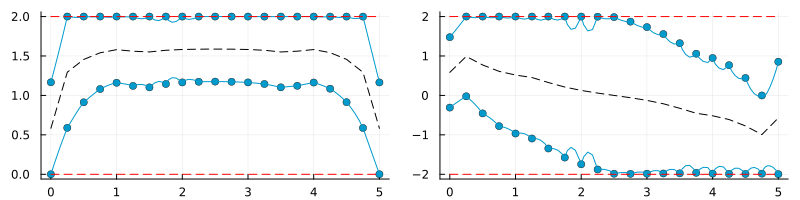

In [106]:
p1 = plot(tnom,unom[1,:],linestyle=:dash,color="black",label="")
scatter!(tnom,unom[1,:]+input_proj_funl_nom[1],color="deepskyblue3",label="")
scatter!(tnom,unom[1,:]-input_proj_funl_nom[1],color="deepskyblue3",label="")
plot!(tprop,uprop[1,:]+input_proj_funl_prop[1],color="deepskyblue3",label="")
plot!(tprop,uprop[1,:]-input_proj_funl_prop[1],color="deepskyblue3",label="")
plot!(tnom,tnom*0 .+ vmax,linestyle=:dash,color="red",label="")
plot!(tnom,tnom*0 .+ vmin,linestyle=:dash,color="red",label="")
p2 = plot(tnom,unom[2,:],linestyle=:dash,color="black",label="")
scatter!(tnom,unom[2,:]+input_proj_funl_nom[2],color="deepskyblue3",label="")
scatter!(tnom,unom[2,:]-input_proj_funl_nom[2],color="deepskyblue3",label="")
plot!(tprop,uprop[2,:]+input_proj_funl_prop[2],color="deepskyblue3",label="")
plot!(tprop,uprop[2,:]-input_proj_funl_prop[2],color="deepskyblue3",label="")
plot!(tnom,tnom*0 .+ wmax,linestyle=:dash,color="red",label="")
plot!(tnom,tnom*0 .+ wmin,linestyle=:dash,color="red",label="")
plot(p1,p2,layout=(1,2),size=(800,200))

# Check CTCS

### Q $\succ$ 0

In [107]:
min_lam_qprop = zeros(size(Qprop,3))
diff_lam_qprop = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_qprop[i] = eigvals[1]
    diff_lam_qprop[i] = abs(eigvals[1] - eigvals[2])
end
min_lam_q = zeros(size(Qnode,3))
diff_lam_q = zeros(size(Qnode,3))
for i in 1:size(Qnode,3)
    eigvals = eigen(Qnode[:,:,i]).values
    min_lam_q[i] = eigvals[1]
    diff_lam_q[i] = abs(eigvals[1] - eigvals[2])
end

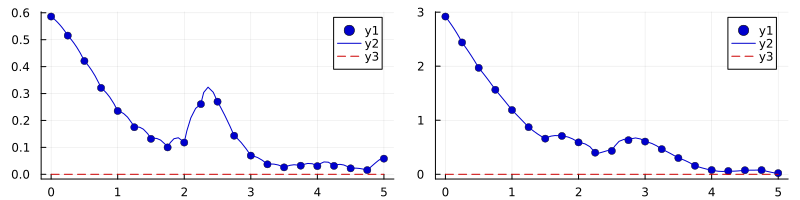

In [108]:
p1 = scatter(tnom,min_lam_q,seriestype="o",size=(500,300),color="blue3")
plot!(tprop,min_lam_qprop,color="blue3")
plot!(tnom,tnom .* 0,linestyle=:dash,color="red3")
p2 = scatter(tnom,diff_lam_q,seriestype="o",size=(500,300),color="blue3")
plot!(tprop,diff_lam_qprop,color="blue3")
plot!(tnom,tnom .* 0,linestyle=:dash,color="red3")
plot(p1,p2,layout=(1,2),size=(800,200))

In [109]:
findfirst(x -> x < 0, min_lam_q)

### Invariance

In [110]:
Cprop = zeros(1, size(Qprop,3))
diff_eig_Cprop = zeros(1, size(Qprop,3))
CLnode = zeros(1, size(Qnode,3)-1)
CRnode = zeros(1, size(Qnode,3)-1)
for i in 1:size(Cprop,2)
    G = - invariance_condition(fs,Qprop[:,:,i],Yprop[:,:,i],Zprop[:,:,i],xprop[:,i],uprop[:,i])
    eigvals = eigen(G).values
    Cprop[1,i] = eigvals[end]
    diff_eig_Cprop[1,i] = abs(eigvals[end] - eigvals[end-1])
end
for i in 1:size(CLnode,2)
    GL = - invariance_condition(fs,Qnode[:,:,i],Ynode[:,:,i],ZLnode[:,:,i],xnom[:,i],unom[:,i])
    eigvals = eigen(GL).values
    CLnode[1,i] = eigvals[end]
end
for i in 1:size(CRnode,2)
    GR = - invariance_condition(fs,Qnode[:,:,i+1],Ynode[:,:,i+1],ZRnode[:,:,i],xnom[:,i+1],unom[:,i+1])
    eigvals = eigen(GR).values
    CRnode[1,i] = eigvals[end]
end

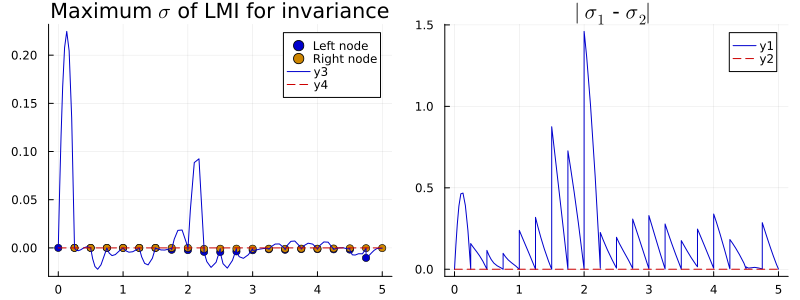

In [111]:
p1 = scatter(tnom[1:end-1],CLnode[1,:],seriestype="o",color="blue3",label="Left node",size=(800,300))
scatter!(p1,tnom[2:end],CRnode[1,:],seriestype="o",color="orange3",label="Right node")
plot!(p1,tprop,Cprop[1,:],color="blue3")
plot!(p1,tnom,tnom .* 0,linestyle=:dash,color="red3")
title!(L"Maximum $\sigma$ of LMI for invariance")
p2 = plot(tprop,diff_eig_Cprop[1,:],color="blue3")
plot!(p2,tnom,tnom .* 0,linestyle=:dash,color="red3")
title!(L"$|\sigma_1$ - $\sigma_2|$")
p = plot(p1,p2,layout=(1,2),size=(800,300))

### Other constraints

In [97]:
N_constraint = size(fs.funl_constraint,1)
Cprop = zeros(N_constraint,size(Qprop,3))
diff_eig_Cprop = zeros(N_constraint,size(Qprop,3))
Cnode = zeros(N_constraint,size(Qnode,3))
for j in 1:N_constraint
    for i in 1:size(Cprop,2)
        G = - impose(fs.funl_constraint[j],Qprop[:,:,i],Yprop[:,:,i],xprop[:,i],uprop[:,i],idx=i)
        eigvals = eigen(G).values
        Cprop[j,i] = eigvals[end]
        diff_eig_Cprop[j,i] = abs(eigvals[end] - eigvals[end-1])
    end
    for i in 1:size(Cnode,2)
        G = - impose(fs.funl_constraint[j],Qnode[:,:,i],Ynode[:,:,i],xnom[:,i],unom[:,i],idx=i)
        eigvals = eigen(G).values
        Cnode[j,i] = eigvals[end]
    end
end

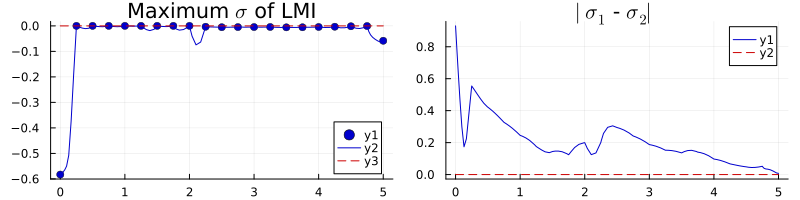

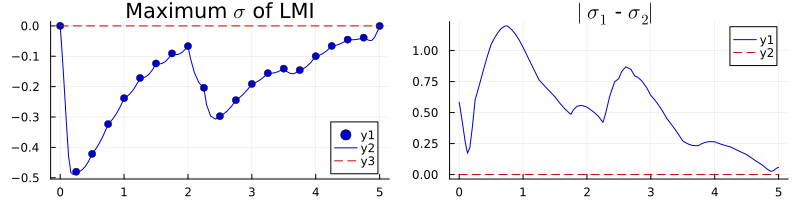

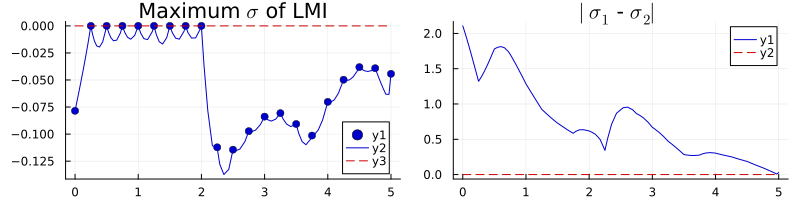

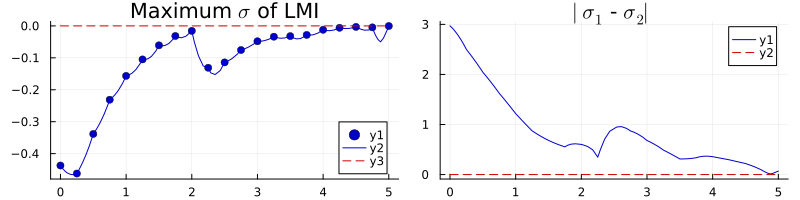

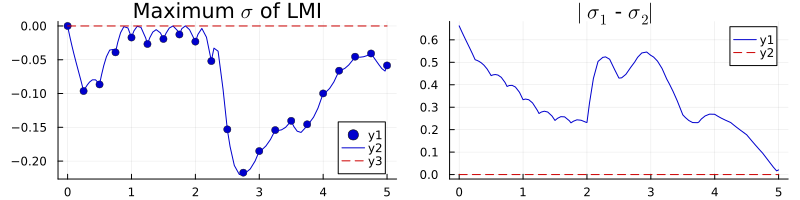

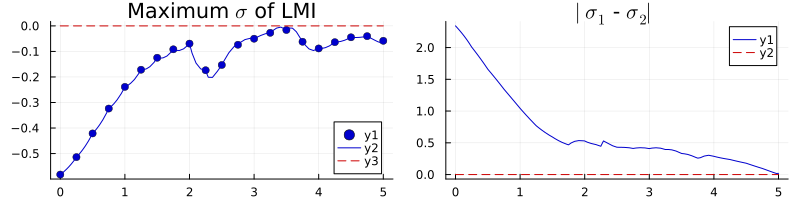

In [98]:
for idx in 1:N_constraint
    # Plots.plot(; size=(500,200))
    p1 = scatter(tnom,Cnode[idx,:],seriestype="o",color="blue3",size=(500,100))
    plot!(p1,tprop,Cprop[idx,:],color="blue3")
    plot!(p1,tnom,tnom .* 0,linestyle=:dash,color="red3")
    title!(L"Maximum $\sigma$ of LMI")
    p2 = plot(tprop,diff_eig_Cprop[idx,:],color="blue3")
    plot!(p2,tnom,tnom .* 0,linestyle=:dash,color="red3")
    title!(L"$|\sigma_1$ - $\sigma_2|$")
    p = plot(p1,p2,layout=(1,2),size=(800,200))
    display(p)
end

# Sampling

In [83]:
xs_list = []
for i in 1:10
    z = randn(ix)
    z = z / norm(z)
    push!(xs_list,xnom[:,1] + sqrt(Qnode[:,:,1]) * z)
end

In [43]:
include("./funlopt/funl_utils.jl")

propagate_from_funnel_entry (generic function with 1 method)

In [44]:
xsam_fwd,tsam,xsam,usam = [],[],[],[]
xnom_sam = []
for xs in xs_list
    xf_,ts_,xsam_,usam_ = propagate_from_funnel_entry(xs,DLMI,dynamics,
        xnom,unom,dtnom,
        fs.solution.X,fs.solution.UL,fs.solution.UR)
    push!(xsam_fwd,xf_)
    push!(tsam,ts_)
    push!(xsam,xsam_)
    push!(usam,usam_)
    # push!(xnom_sam,xnom_)
end

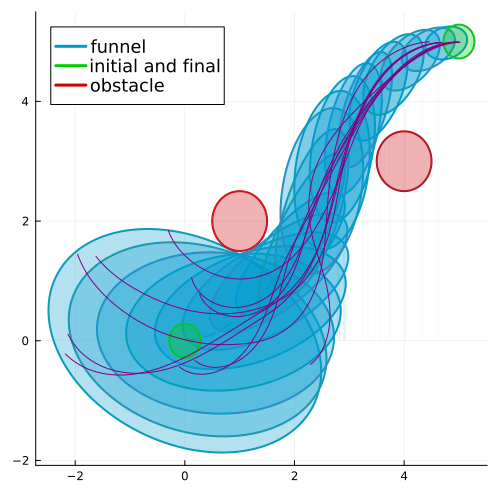

In [45]:
p2 = Plots.plot(; size=(500,500))
plot!(xnom[1,:],xnom[2,:],c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
for idx in 1:N
    label = nothing
    if idx == 1
        label = "funnel"
    end
    plot_ellipse(p2,Qnode[:,:,idx],xnom[:,idx],"deepskyblue3",label=label)
end
plot_ellipse(p2,fs.solution.Qi,xnom[:,1],"green3",label="initial and final")
plot_ellipse(p2,fs.solution.Qf,xnom[:,end],"green3")
for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
    label = nothing
    if idx == 1
        label = "obstacle"
    end
    plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
end
for x_ in xsam
    plot!(x_[1,:],x_[2,:],color="purple",label=nothing)
end
display(p2)

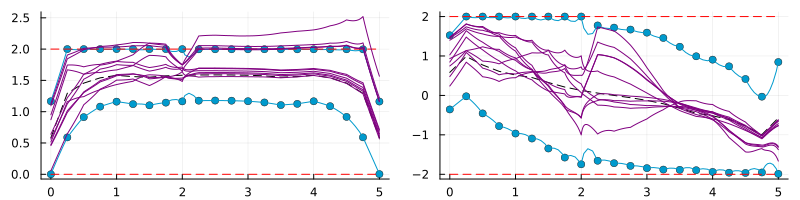

In [46]:
p1 = plot(tnom,unom[1,:],linestyle=:dash,color="black",label="")
scatter!(tnom,unom[1,:]+input_proj_funl_nom[1],color="deepskyblue3",label="")
scatter!(tnom,unom[1,:]-input_proj_funl_nom[1],color="deepskyblue3",label="")
plot!(tprop,uprop[1,:]+input_proj_funl_prop[1],color="deepskyblue3",label="")
plot!(tprop,uprop[1,:]-input_proj_funl_prop[1],color="deepskyblue3",label="")
plot!(tnom,tnom*0 .+ vmax,linestyle=:dash,color="red",label="")
plot!(tnom,tnom*0 .+ vmin,linestyle=:dash,color="red",label="")
for (t_,u_) in zip(tsam,usam)
    plot!(t_,u_[1,:],color="purple",label=nothing)
end
p2 = plot(tnom,unom[2,:],linestyle=:dash,color="black",label="")
scatter!(tnom,unom[2,:]+input_proj_funl_nom[2],color="deepskyblue3",label="")
scatter!(tnom,unom[2,:]-input_proj_funl_nom[2],color="deepskyblue3",label="")
plot!(tprop,uprop[2,:]+input_proj_funl_prop[2],color="deepskyblue3",label="")
plot!(tprop,uprop[2,:]-input_proj_funl_prop[2],color="deepskyblue3",label="")
plot!(tnom,tnom*0 .+ wmax,linestyle=:dash,color="red",label="")
plot!(tnom,tnom*0 .+ wmin,linestyle=:dash,color="red",label="")
for (t_,u_) in zip(tsam,usam)
    plot!(t_,u_[2,:],color="purple",label=nothing)
end
plot(p1,p2,layout=(1,2),size=(800,200))

## solve time per Nsub

In [132]:
list_Nsub = 1:30
list_time_solve = []
for Nsub in list_Nsub
    param["Nsub"] = Nsub
    fs = FunnelSynthesis(param,dynamics,DLMI,list_const,scaler)
    time_dict = run(fs,Xnom,ULnom,URnom,Qini,Qf,xnom,unom,dtnom,"Mosek")
    push!(list_time_solve,time_dict["time_solve"])
end

|1      |-2.94       |-1.000    |-2.937     |-1.000     |-1.000    |-Inf     | 0.3      |-8.2e+00   |
|1      |-2.87       |-1.000    |-2.865     |-1.000     |-1.000    |-Inf     | 0.2      |-7.7e+00   |
|1      |-2.86       |-1.000    |-2.864     |-1.000     |-1.000    |-Inf     | 0.2      |-8.1e+00   |
|1      |-2.86       |-1.000    |-2.864     |-1.000     |-1.000    |-Inf     | 0.2      |-9.2e+00   |
|1      |-2.86       |-1.000    |-2.861     |-1.000     |-1.000    |-Inf     | 0.2      |-8.6e+00   |
|1      |-2.86       |-1.000    |-2.862     |-1.000     |-1.000    |-Inf     | 0.2      |-7.6e+00   |
|1      |-2.86       |-1.000    |-2.861     |-1.000     |-1.000    |-Inf     | 0.2      |-8.1e+00   |
|1      |-2.86       |-1.000    |-2.861     |-1.000     |-1.000    |-Inf     | 0.2      |-7.9e+00   |
|1      |-2.86       |-1.000    |-2.861     |-1.000     |-1.000    |-Inf     | 0.2      |-7.7e+00   |
|1      |-2.86       |-1.000    |-2.861     |-1.000     |-1.000    |-Inf     | 0.2

In [133]:
list_time_solve

30-element Vector{Any}:
  0.11986804008483887
  0.22455191612243652
  0.38834595680236816
  0.5879178047180176
  1.1473748683929443
  1.3421151638031006
  1.7894980907440186
  2.5759010314941406
  2.8664469718933105
  3.3871068954467773
  ⋮
 15.468570947647095
 16.566149950027466
 17.222512006759644
 18.554970026016235
 21.71104907989502
 23.527633905410767
 26.012106895446777
 27.6836359500885
 27.897897958755493

In [138]:
p = plot(list_Nsub,list_time_solve,seriestype=:line, marker=:circle,label="")
savefig("./data_image/solve_time_per_Nsub.pdf")

"/Users/taewankim/Documents/Code/Personal/Funnel_CTCS/data_image/solve_time_per_Nsub.pdf"